# 1. Importing Libraries and Reading Data

In [1]:
pip uninstall tensorflow tensorflow-text tensorflow-hub -y

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: tensorflow-text 2.15.0
Uninstalling tensorflow-text-2.15.0:
  Successfully uninstalled tensorflow-text-2.15.0
Found existing installation: tensorflow-hub 0.16.1
Uninstalling tensorflow-hub-0.16.1:
  Successfully uninstalled tensorflow-hub-0.16.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow==2.15.0 tensorflow-text==2.15.0 tensorflow-hub==0.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import spacy
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.utils import resample
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import warnings
warnings.filterwarnings('ignore')

2024-08-23 09:33:38.431268: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 09:33:38.431320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 09:33:38.433085: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv')
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
print('The datatype and other basic info about the dataset are as follows:')
df.info()
print('*'*50)
print(f'The shape of the dataset is: {df.shape}')
print('*'*50)
print(f'The columns in the dataset are: {df.columns}')

The datatype and other basic info about the dataset are as follows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
**************************************************
The shape of the dataset is: (53043, 3)
**************************************************
The columns in the dataset are: Index(['Unnamed: 0', 'statement', 'status'], dtype='object')


1. Both 'statement' and 'status' are of datatype 'O'.
2. Column 'Unnamed: 0' seems unwanted.
3. There seems null values in 'statement'.

In [6]:
df.drop('Unnamed: 0',axis=1,inplace =True)
df.reset_index(drop=True)
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


# 2. EDA and Data Preparation

In [7]:
for feature in df.columns:
    if df[feature].isnull().sum() >1:
        print(feature)
        print(f'The count of null values for is: {df[feature].isnull().sum()}')
        print(f'The percentage of null values is: {np.round(df[feature].isnull().mean(),4)}%')
        print('*'*50)

statement
The count of null values for is: 362
The percentage of null values is: 0.0068%
**************************************************


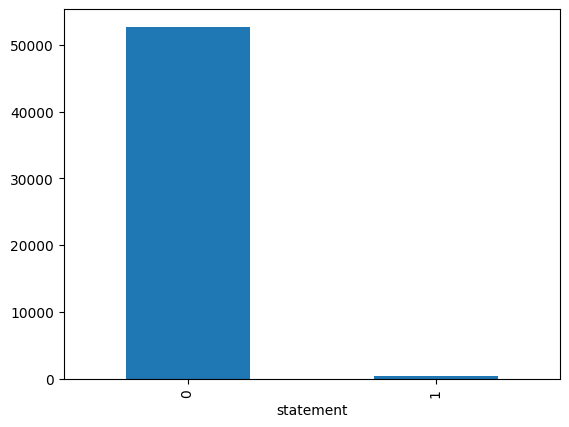

In [8]:
for feature in df.columns:
    if df[feature].isnull().sum() >1:
        data = df.copy()
        
        data[feature] = np.where(df[feature].isnull(),1,0)
        data.groupby(feature)['status'].count().plot(kind='bar')

From the analysis it's clear that NaN values don't have much impact and can be dropped.

In [9]:
df.dropna(inplace = True)
df.isnull().sum()

statement    0
status       0
dtype: int64

Text(0, 0.5, 'Count')

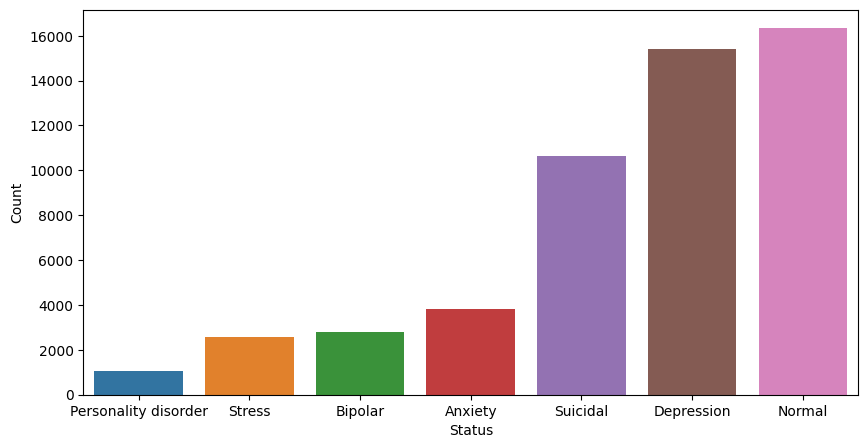

In [10]:
data = df.groupby('status')['statement'].count().sort_values().reset_index()
plt.figure(figsize = (10,5))
sns.barplot(data=data,x=feature,y='statement')
plt.xlabel('Status')
plt.ylabel('Count')

1. Majority of the population do not suffer from mental health issues.
2. Among the people suffering from mental health issues, depression and suidical is most common.
3. There can be relation between depression and suicide as most people suffering depression tend to get suicidal thoughts.

In [11]:
df.describe()

,statement,status
count,52681,52681
unique,51073,7
top,what do you mean?,Normal
freq,22,16343


In [12]:
df[df['statement']== 'what do you mean?']

,statement,status
31098,what do you mean?,Normal
31216,what do you mean?,Normal
31377,what do you mean?,Normal
31522,what do you mean?,Normal
31606,what do you mean?,Normal
31675,what do you mean?,Normal
31788,what do you mean?,Normal
31882,what do you mean?,Normal
31981,what do you mean?,Normal
32022,what do you mean?,Normal


1. The phrase "what do you mean?" appears most frequently, occurring 22 times. This suggests that this phrase might be commonly used in the dataset, potentially indicating confusion, clarification, or a repeated question in conversations or data collection.
2. The phrase is used only by normal people, it's a clear indication that such people haven't experienced mental health problems and cannot relate to what is being asked.

In [13]:
df['statement_length'] = df['statement'].apply(len)
df['num_words'] = df['statement'].apply(lambda x: len(x.split()))
df['avg_word_length'] = np.round(df['statement_length'] / df['num_words'])
df['avg_word_length'] = df['avg_word_length'].map(int)
df['vocabulary_size'] = df['statement'].apply(lambda x: len(set(x.split())))
df.head()

,statement,status,statement_length,num_words,avg_word_length,vocabulary_size
0,oh my gosh,Anxiety,10,3,3,3
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,10,6,10
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,14,6,13
3,I've shifted my focus to something else but I'...,Anxiety,61,11,6,11
4,"I'm restless and restless, it's been a month n...",Anxiety,72,14,5,14


In [14]:
num_feature = [feature for feature in df.columns if df[feature].dtype != 'O']

num_feature

['statement_length', 'num_words', 'avg_word_length', 'vocabulary_size']

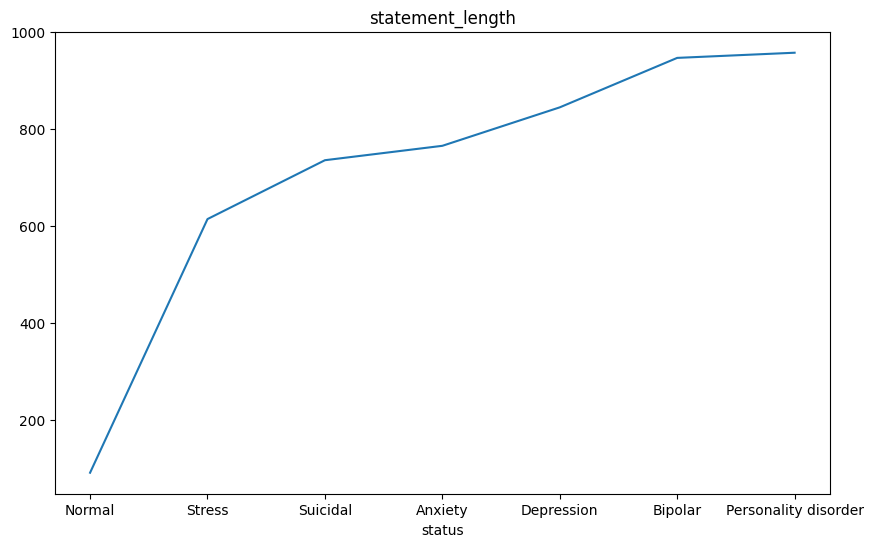

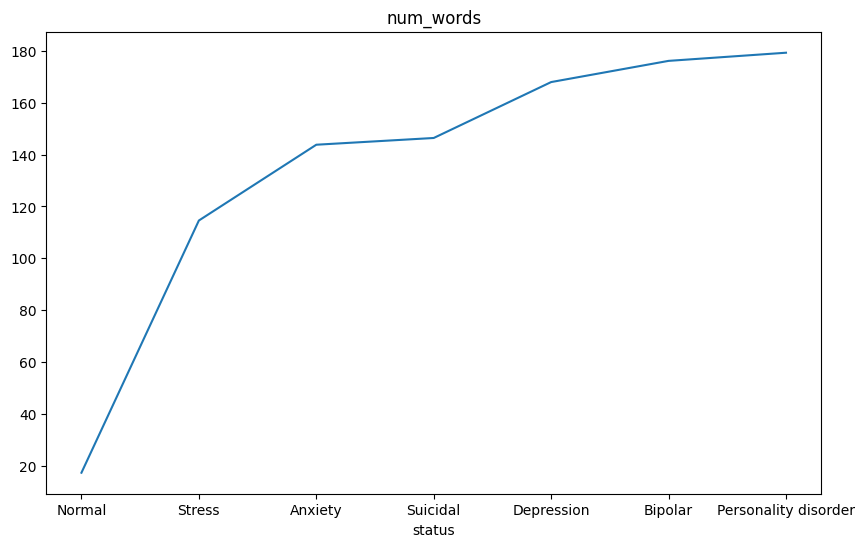

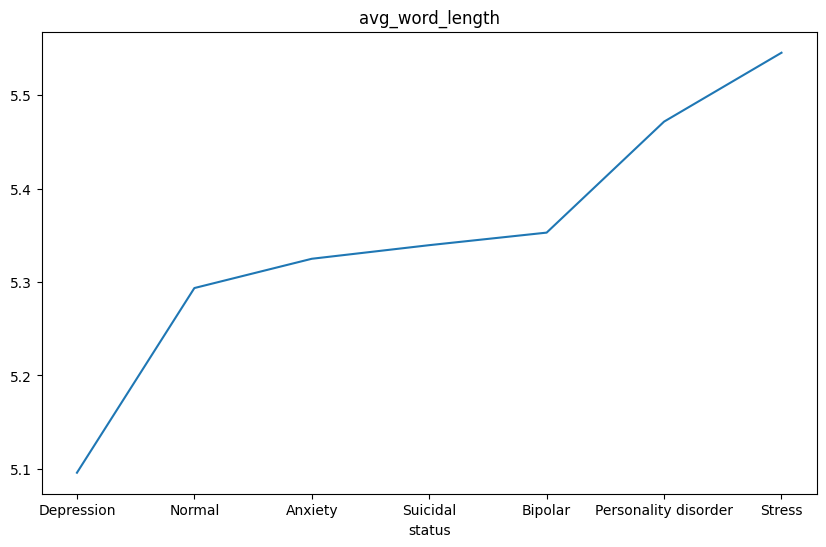

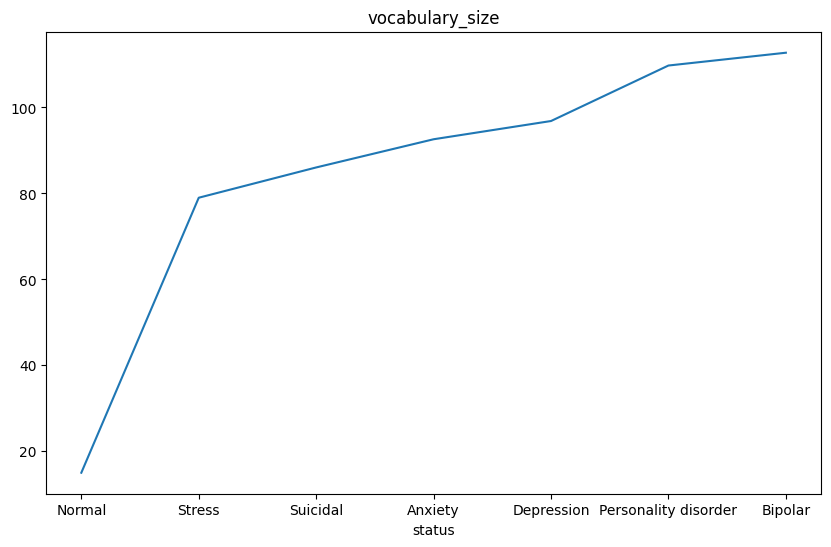

In [15]:
for feature in num_feature:
    plt.figure(figsize= (10,6))
    df.groupby('status')[feature].mean().sort_values().plot()
    plt.title(feature)
    plt.show()

It clearly seems like normal people speak the least since they don't have any mental health issues to explain.

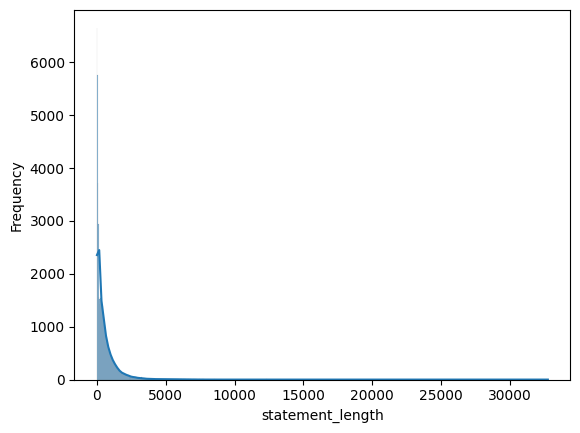

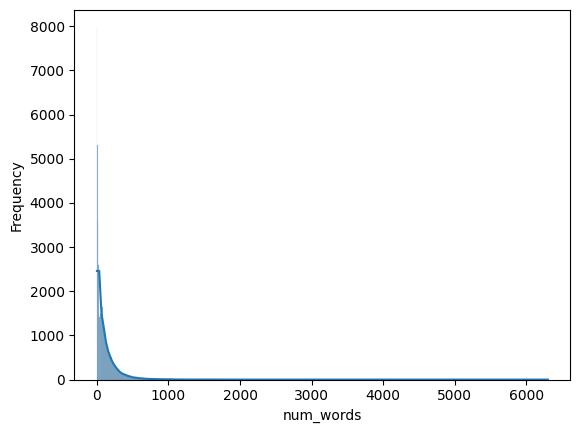

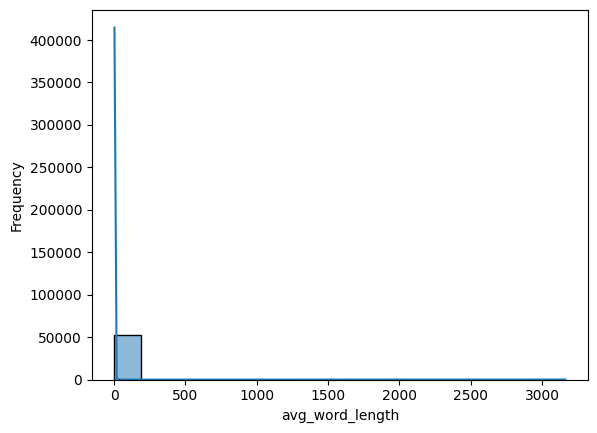

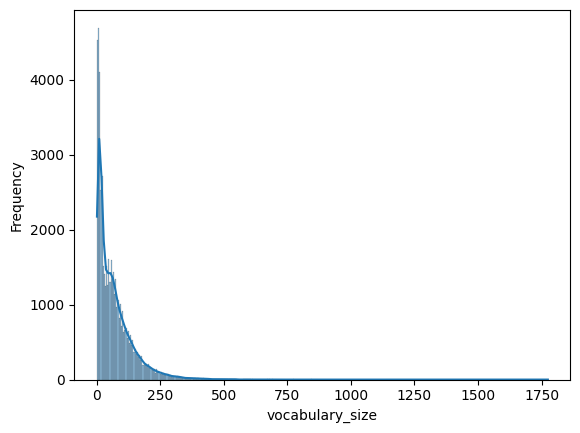

In [16]:
for feature in num_feature:
    sns.histplot(data = df, x=feature,kde=True)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

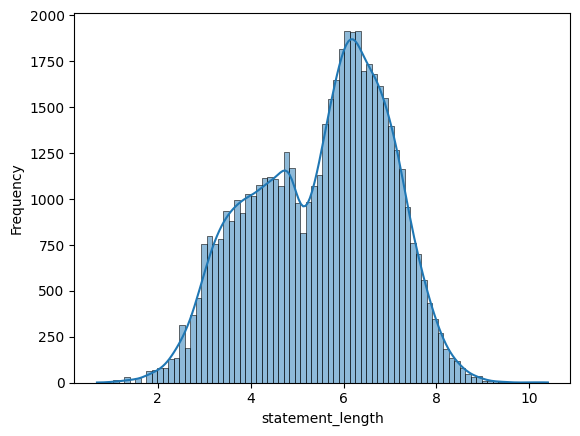

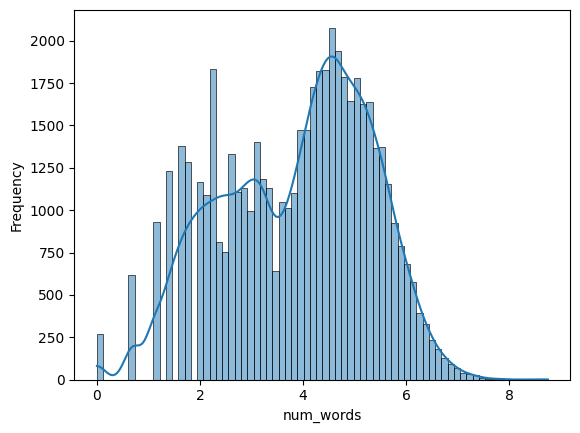

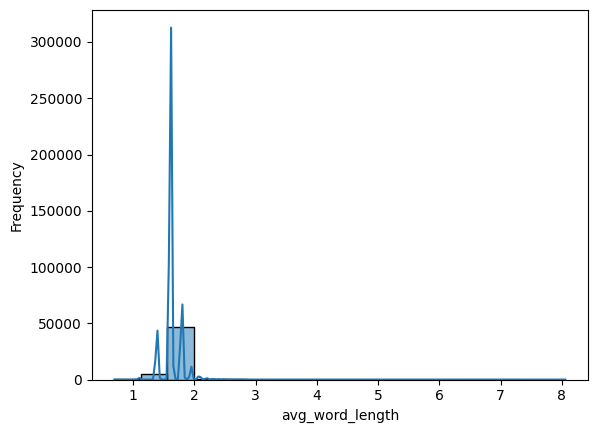

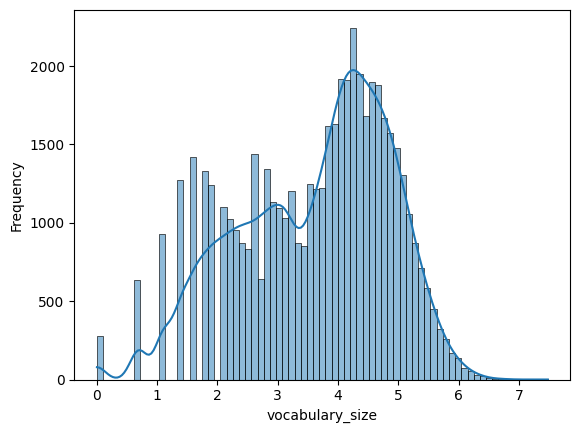

In [17]:
for feature in num_feature:
    data = df.copy()
    data[feature] = np.log(data[feature])
    sns.histplot(data = data, x=feature,kde=True)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

Looks heavily skewed to the right. This could introduce bias and impact performance of model. To remove the impact of outliers, log transformation is applied that makes the distribution centered and normalized.

In [18]:
for feature in num_feature:
    df[feature] = np.log(df[feature])

df.head()

,statement,status,statement_length,num_words,avg_word_length,vocabulary_size
0,oh my gosh,Anxiety,2.302585,1.098612,1.098612,1.098612
1,"trouble sleeping, confused mind, restless hear...",Anxiety,4.158883,2.302585,1.791759,2.302585
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,4.356709,2.639057,1.791759,2.564949
3,I've shifted my focus to something else but I'...,Anxiety,4.110874,2.397895,1.791759,2.397895
4,"I'm restless and restless, it's been a month n...",Anxiety,4.276666,2.639057,1.609438,2.639057


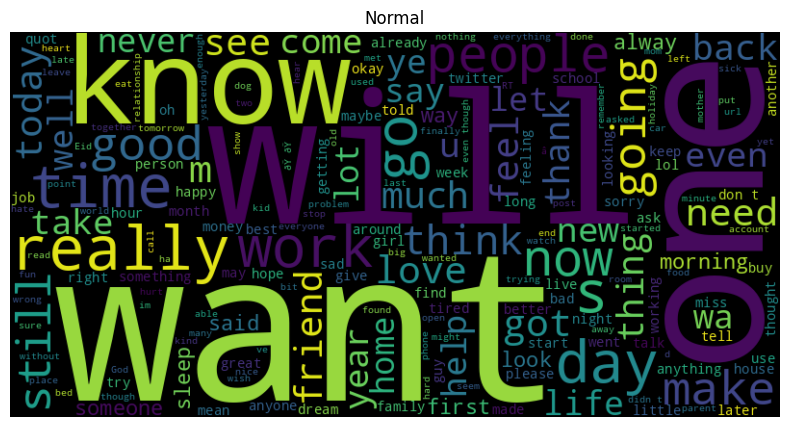

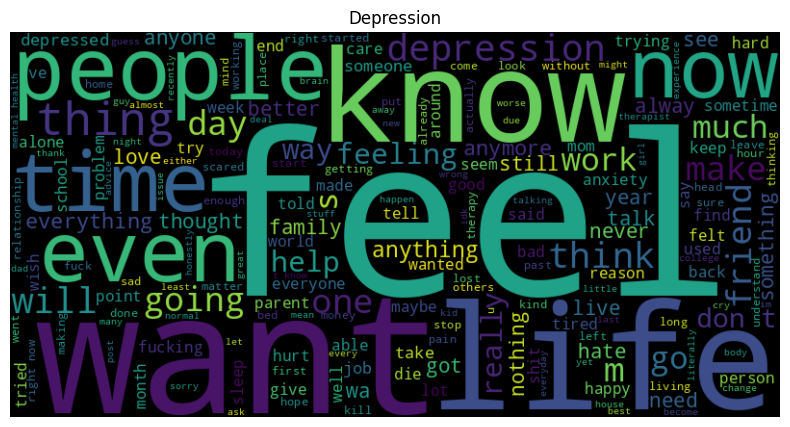

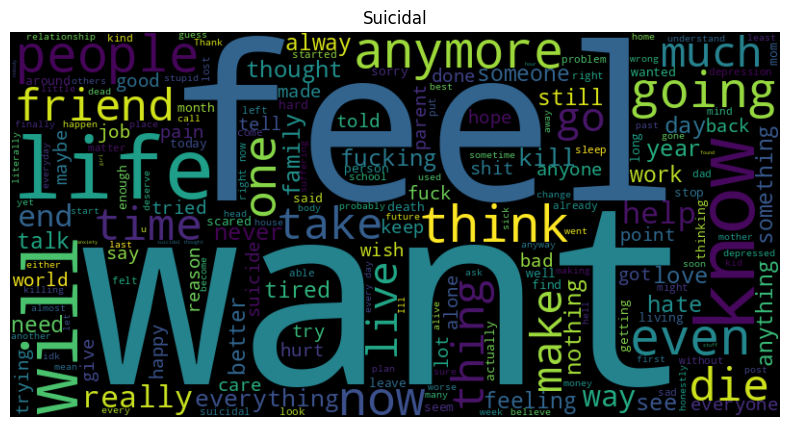

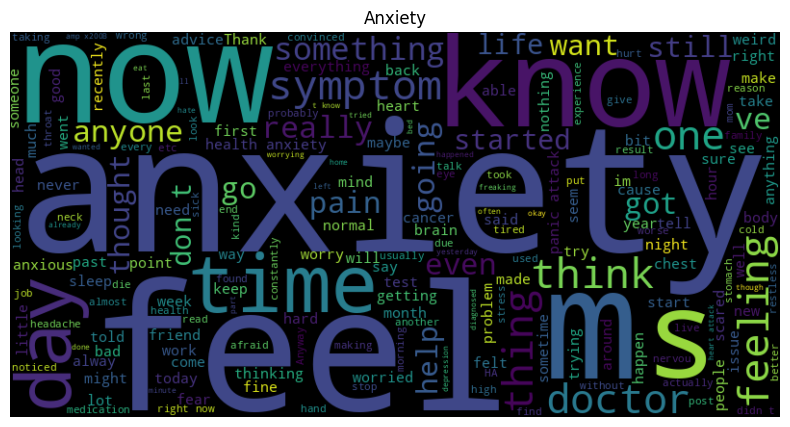

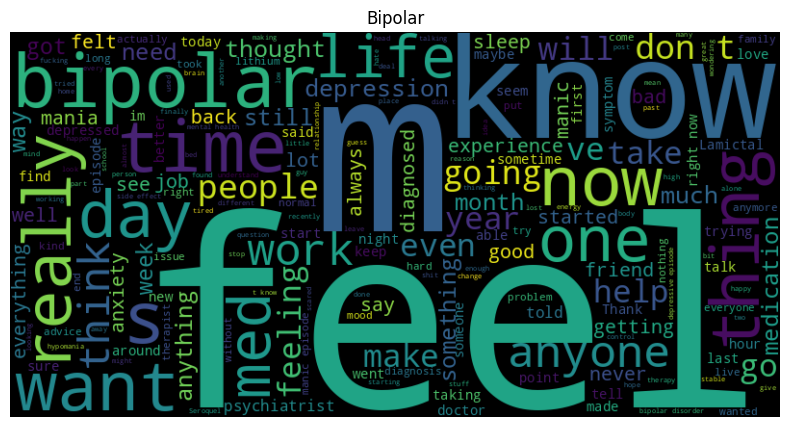

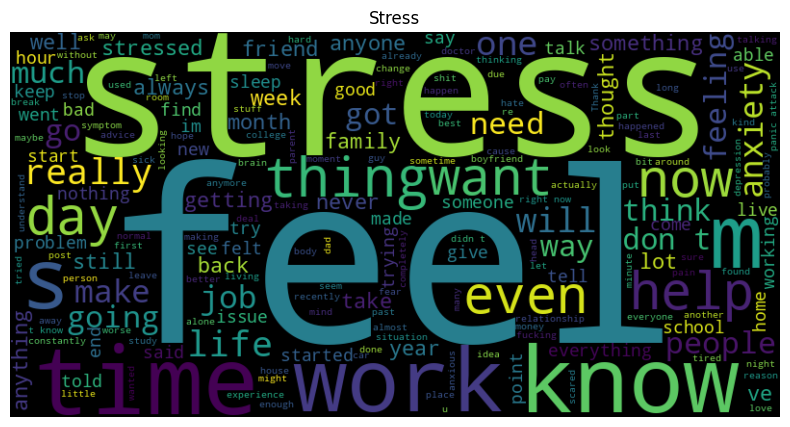

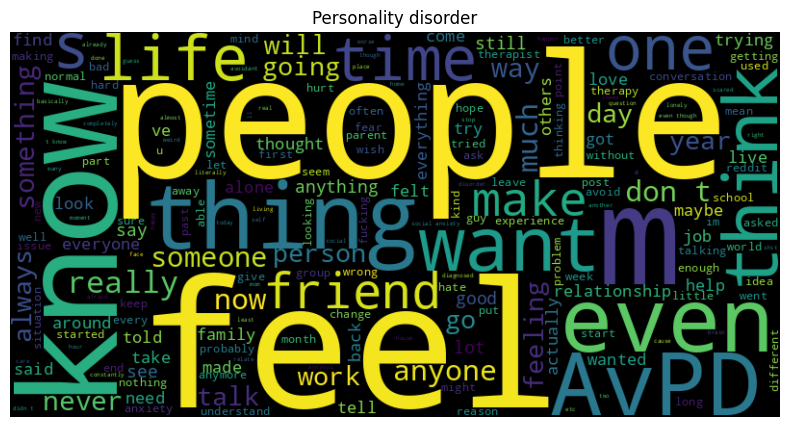

In [19]:
categories = df['status'].value_counts().index

for cat in categories:
    statements = " ".join(df[df['status']==cat]['statement'])
    
    wordcloud = WordCloud(width=800, height=400).generate(statements)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(cat)
    plt.axis('off')
    plt.show()

In [20]:
#Converting Labels into numbers

label_ordered = df['status'].value_counts().index

label_ordered = {k:i for i,k in enumerate(label_ordered,0)}

df['status'] = df['status'].map(label_ordered)
df.head()

,statement,status,statement_length,num_words,avg_word_length,vocabulary_size
0,oh my gosh,3,2.302585,1.098612,1.098612,1.098612
1,"trouble sleeping, confused mind, restless hear...",3,4.158883,2.302585,1.791759,2.302585
2,"All wrong, back off dear, forward doubt. Stay ...",3,4.356709,2.639057,1.791759,2.564949
3,I've shifted my focus to something else but I'...,3,4.110874,2.397895,1.791759,2.397895
4,"I'm restless and restless, it's been a month n...",3,4.276666,2.639057,1.609438,2.639057


<Axes: >

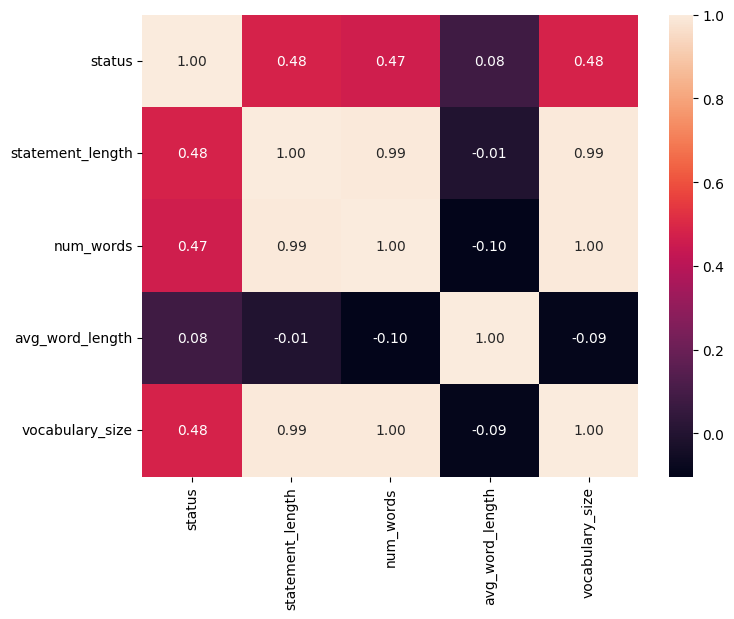

In [21]:
cm = df[['status','statement_length','num_words','avg_word_length','vocabulary_size']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True, fmt=".2f")

# 3. Modelling

In [22]:
df_sample = df.sample(n=20000,random_state=2024)
majority_size = len(df_sample[df_sample['status']==0])

def resampling(df):
  minority_resample = resample(df,replace=True, n_samples=majority_size,random_state=22)
  return minority_resample

In [23]:
df_sample_1 = resampling(df_sample[df_sample['status']==1])
df_sample_2 = resampling(df_sample[df_sample['status']==2])
df_sample_3 = resampling(df_sample[df_sample['status']==3])
df_sample_4 = resampling(df_sample[df_sample['status']==4])
df_sample_5 = resampling(df_sample[df_sample['status']==5])
df_sample_6 = resampling(df_sample[df_sample['status']==6])

df_new =pd.concat([df_sample[df_sample['status']==0],df_sample_1,df_sample_2,df_sample_3,df_sample_4,df_sample_5,df_sample_6], axis=0).reset_index(drop=True)
df_new['status'].value_counts()


status
0    6140
1    6140
2    6140
3    6140
4    6140
5    6140
6    6140
Name: count, dtype: int64

In [24]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)


embedding_model = tf.keras.Model(inputs=[text_input], outputs=[outputs['pooled_output']])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_new['statement'], df_new['status'], test_size=0.2, random_state=42)

train_embeddings = embedding_model.predict(X_train)
test_embeddings = embedding_model.predict(X_test)

269/269 [==============================] - 85s 315ms/step


In [26]:
xgb = XGBClassifier(alpha=0.5, lambda_=1.0,learning_rate=0.05, n_estimators=500)
model = xgb.fit(train_embeddings, y_train,
                eval_set=[(test_embeddings, y_test)], early_stopping_rounds=10)
y_pred = model.predict(test_embeddings)

[0]	validation_0-mlogloss:1.89406
[1]	validation_0-mlogloss:1.84617
[2]	validation_0-mlogloss:1.80288
[3]	validation_0-mlogloss:1.76234
[4]	validation_0-mlogloss:1.72481
[5]	validation_0-mlogloss:1.68937
[6]	validation_0-mlogloss:1.65522
[7]	validation_0-mlogloss:1.62256
[8]	validation_0-mlogloss:1.59099
[9]	validation_0-mlogloss:1.56249
[10]	validation_0-mlogloss:1.53420
[11]	validation_0-mlogloss:1.50776
[12]	validation_0-mlogloss:1.48295
[13]	validation_0-mlogloss:1.45837
[14]	validation_0-mlogloss:1.43526
[15]	validation_0-mlogloss:1.41245
[16]	validation_0-mlogloss:1.39176
[17]	validation_0-mlogloss:1.37041
[18]	validation_0-mlogloss:1.35027
[19]	validation_0-mlogloss:1.33092
[20]	validation_0-mlogloss:1.31242
[21]	validation_0-mlogloss:1.29391
[22]	validation_0-mlogloss:1.27524
[23]	validation_0-mlogloss:1.25827
[24]	validation_0-mlogloss:1.24116
[25]	validation_0-mlogloss:1.22507
[26]	validation_0-mlogloss:1.20942
[27]	validation_0-mlogloss:1.19374
[28]	validation_0-mlogloss:1.1

# 4. Results

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1260
           1       0.88      0.82      0.85      1220
           2       0.88      0.88      0.88      1187
           3       0.97      0.99      0.98      1252
           4       0.97      1.00      0.98      1215
           5       0.96      0.99      0.98      1210
           6       1.00      1.00      1.00      1252

    accuracy                           0.94      8596
   macro avg       0.94      0.94      0.94      8596
weighted avg       0.94      0.94      0.94      8596



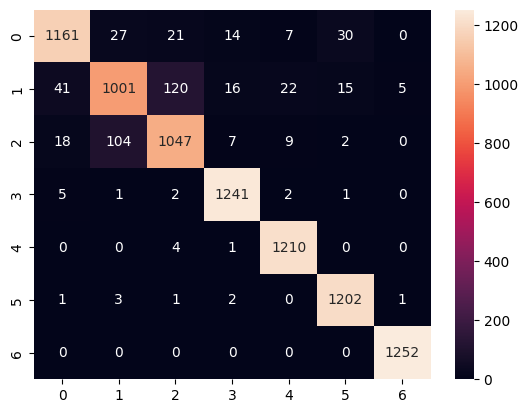

In [27]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot =True, fmt='d')
print(classification_report(y_test,y_pred))